In [1]:
import numpy as np
import pandas as pd
import os
from os.path import join

import json
import requests
import xmltodict
import re
import time
import random

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
dataDir = '../data'

In [12]:
pubDates_df = pd.read_csv(join(dataDir, 'processed', 'publicationDates.csv'))

# Tools for processing the citation data

In [3]:
citeFile = join(dataDir, 'articleCitations.json')

In [4]:
# read in the full citations database
citations = []
with open(citeFile) as f:
    for i,line in enumerate(f):
        thisCite = json.loads(line)
        citations.append(thisCite)

Tools that will summarize the citations for a given PMCID. 
See all of the primary and secondary articles that cite a given PMCID. 
Or, see all of the primary and secondary articles that a given PMCID cites. 

In [51]:
def getCitations(PMCID, covidOnly=True):
    """
    For the given PMCID, get the IDs of all articles that this article cites. 
    "covidOnly" flag indicates whether to search across all citations or only 
    those within the PMC COVID database
    """
    theseCitations = next((x for x in citations if x['PMCID'] == PMCID ), None)
    if not theseCitations:
        return None
    
    if covidOnly:
        return theseCitations['citations_covid']
    else:
        return theseCitations['citations']
    
def getCitationsSummary(PMCID):
    """
    For the given PMCID, return a dictionary summarizing the citations for this id.
    Dictionary includes:
        - primary citations's: IDs of articles cited by the current ID
        - secondary citations's: IDs of articles cited by the articles that cite the current ID
        - nUniqueIds: the number of unique IDs cited by this article, primary or secondary
        - uniqueIdDates: dataframe of unique IDs alongside the publication date of each ID
    """
    # get the primary IDs
    primaryIDs = getCitations(PMCID, covidOnly=True)
    
    # get the secondary IDs
    secondaryIDs = []
    for pid in primaryIDs:
        IDs = getCitations(pid, covidOnly=True)
        secondaryIDs = secondaryIDs + IDs
        
    # get the set of unique IDs
    uniqueIDs = list(set(primaryIDs + secondaryIDs))
    
    # get the publication date for each uniqueID
    uniqueIDsDates = []
    for uid in uniqueIDs:
        uniqueIDsDates.append({
            'PMCID': uid,
            'pubDate': get_pubDate(uid)
        })
    uniqueIDsDates_df = pd.DataFrame(uniqueIDsDates)
    
    # put it all together
    return {
        'primary': primaryIDs,
        'secondary': secondaryIDs,
        'nUnique': len(uniqueIDs),
        'pubDates': uniqueIDsDates_df
    }

def getCitedBy(PMCID, covidOnly=True):
    """
    For the given PMCID, get the IDS of all articles that cite it. 
    'covidOnly' flag indicates whether to search in the all citations or
    only those within the PMC COVID database
    """
    theseCitations = next((x for x in citations if x['PMCID'] == PMCID ), None)
    if not theseCitations:
        return None
    
    if covidOnly:
        return theseCitations['citedBy_covid']
    else:
        return theseCitations['citedBy']

def get_pubDate(PMCID):
    match = pubDates_df[pubDates_df['PMCID'] == PMCID]
    if match.empty:
        return None
    return match.iloc[0]['pubDate']

def getCitedBySummary(PMCID):
    """
    For the given PMCID, return a dictionary summarizing the citedBy's for this id.
    Dictionary includes:
        - primary citedBy's: IDs of articles that directly cite the given ID
        - secondary citedBy's: IDs of articles that cite the primary citedBy's
        - nUniqueIds: the number of unique IDs that cite this ID, primary or secondary
        - uniqueIdDates: dataframe of unique IDs alongside the publication date of each ID
    """
    # get the primary IDs
    primaryIDs = getCitedBy(PMCID, covidOnly=True)
    
    # get the secondary IDs
    secondaryIDs = []
    for pid in primaryIDs:
        IDs = getCitedBy(pid, covidOnly=True)
        secondaryIDs = secondaryIDs + IDs
        
    # get the set of unique IDs
    uniqueIDs = list(set(primaryIDs + secondaryIDs))
    
    # get the publication date for each uniqueID
    uniqueIDsDates = []
    for uid in uniqueIDs:
        uniqueIDsDates.append({
            'PMCID': uid,
            'pubDate': get_pubDate(uid)
        })
    uniqueIDsDates_df = pd.DataFrame(uniqueIDsDates)
    
    # put it all together
    return {
        'primary': primaryIDs,
        'secondary': secondaryIDs,
        'nUnique': len(uniqueIDs),
        'pubDates': uniqueIDsDates_df
    }
        
    

In [56]:
testCitations = [x for x in citations if x['nCitedBy_covid'] > 50]
a = getCitedBySummary(citations[10]['PMCID'])
b = getCitationsSummary(citations[10]['PMCID'])

In [59]:
testDates = a['pubDates']
testDates.shape

(84, 2)

In [60]:
testDates.dropna(inplace=True)
testDates.shape

(84, 2)

<AxesSubplot:xlabel='pubDate'>

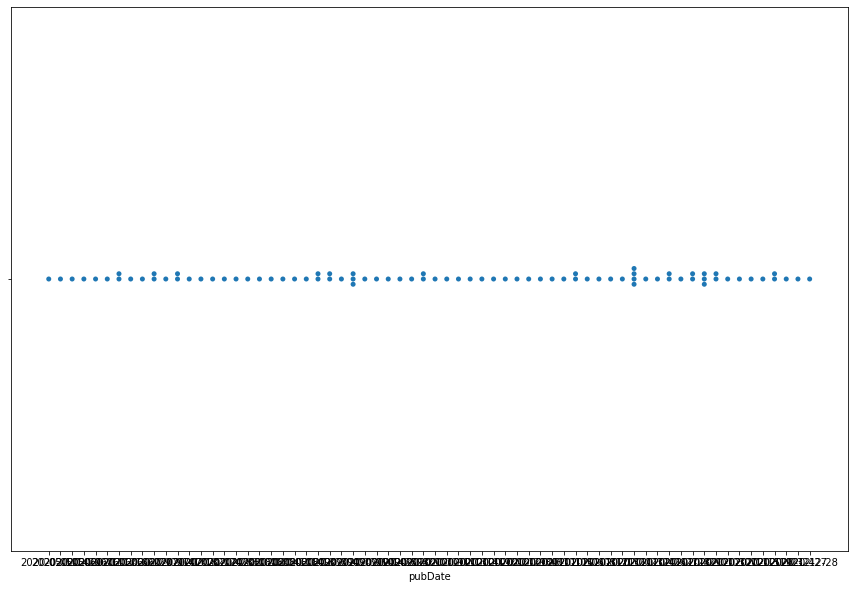

In [61]:
plt.figure(figsize=(15, 10))
sns.swarmplot(x=testDates['pubDate'])

## Lookup citations for key papers

### Important late papers
* Moderna Vax: PMC7787219
* Pfizer Vax: PMC7745181


### Important early papers
* Cyro-EM structure of spike protein: PMC7164637

In [66]:
modernaID = 'PMC7787219'
pfizerID = 'PMC7745181'
spikeID = 'PMC7164637'

In [67]:
# check if the spike protein paper is in the moderna citations list
modernaCitations = getCitationsSummary(modernaID)

uniqueIDs = modernaCitations['primary'] + modernaCitations['secondary']
spikeID in uniqueIDs

True

In [68]:
# check if the spike protein paper is in the pfizer citations list
pfizerCitations = getCitationsSummary(pfizerID)

uniqueIDs = pfizerCitations['primary'] + pfizerCitations['secondary']
spikeID in uniqueIDs

True

In [71]:
pfizerCitations

{'primary': ['PMC7164637', 'PMC7583697', 'PMC7081172'],
 'secondary': ['PMC7159299',
  'PMC7135076',
  'PMC7159286',
  'PMC7159086',
  'PMC7121484',
  'PMC7094943',
  'PMC7081895',
  'PMC7114094',
  'PMC7095418',
  'PMC7048180',
  'PMC7426916',
  'PMC7302472',
  'PMC7164637',
  'PMC7377258',
  'PMC7153529',
  'PMC7120970',
  'PMC7159299',
  'PMC7159286',
  'PMC7092803',
  'PMC7121484',
  'PMC7074197',
  'PMC7014672'],
 'nUnique': 21,
 'pubDates':          PMCID     pubDate
 0   PMC7164637  2020-02-19
 1   PMC7081895  2020-03-17
 2   PMC7114094  2020-02-10
 3   PMC7153529  2020-04-13
 4   PMC7120970  2020-03-05
 5   PMC7159286  2020-01-24
 6   PMC7074197  2020-02-17
 7   PMC7014672  2020-02-06
 8   PMC7094943  2020-02-03
 9   PMC7426916  2020-08-13
 10  PMC7159086  2020-01-30
 11  PMC7048180  2020-02-17
 12  PMC7095418  2020-02-03
 13  PMC7302472  2020-06-19
 14  PMC7092803  2020-02-20
 15  PMC7121484  2020-03-26
 16  PMC7583697  2020-10-14
 17  PMC7135076  2020-01-30
 18  PMC7159299  2

In [72]:
# get total ids for spikeID
spikeCitedBys = getCitedBySummary(spikeID)

In [73]:
spikeCitedBys['nUnique']

12203

In [74]:
len(spikeCitedBys['primary'])

1474